In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import numpy as np
from scipy import interpolate

# Input data

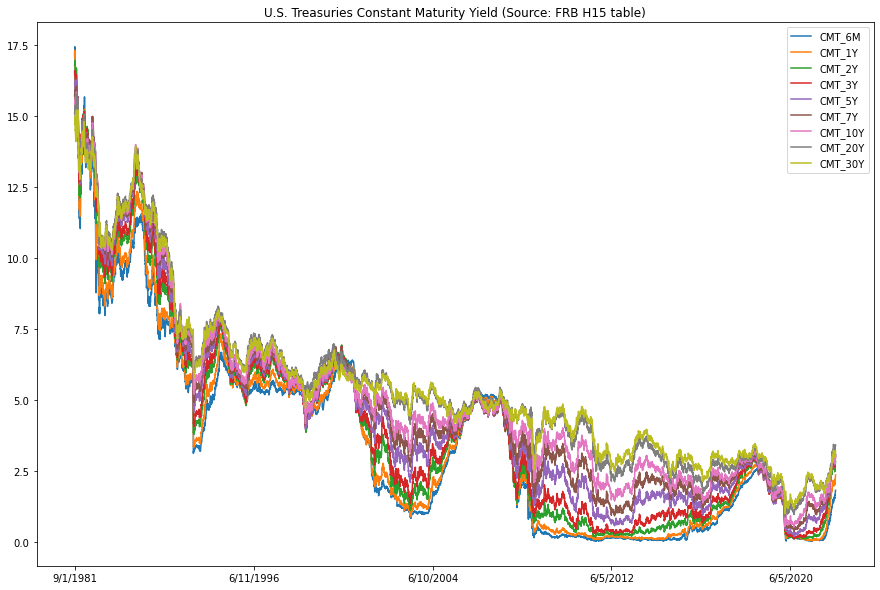

In [2]:
h15 = pd.read_csv("FRB_H15.csv", index_col=0, na_values="ND").dropna()
h15.plot(title="U.S. Treasuries Constant Maturity Yield (Source: FRB H15 table)")
maturity_h15 = [0.5, 1, 2, 3, 5, 7, 10, 20, 30]
spot_rate_maturity = np.insert(np.arange(30)+1.0, 0, 0.5)
extended_spot_rate_maturity = 0.5 + np.arange(60)*0.5
pyld = h15.values[-100]

# Bootstrap to convert par to spot curve

In [3]:
def par_to_spot(pyld, maturity_h15, spot_rate_maturity, extended_spot_rate_maturity):
    pyld = interpolate.pchip_interpolate(maturity_h15, pyld,
                                         spot_rate_maturity)
    pyld = np.interp(extended_spot_rate_maturity, spot_rate_maturity, pyld)
    syld = np.empty(pyld.shape)
    # Set spot yield at 0.5 years maturity to be same as par yield
    syld[0] = pyld[0] / 100.0
    for i in np.arange(1, len(extended_spot_rate_maturity)):
        y_T = pyld[i] / 100.0
        T = extended_spot_rate_maturity[i]
        syld[i] = (
            (1 + 0.5 * y_T) /
            (1 - np.sum(0.5 * y_T /
                        (1 + syld[0:i])**extended_spot_rate_maturity[0:i])))**(1 / T) - 1
    syld = 100.0 * syld[np.searchsorted(extended_spot_rate_maturity,
                                        spot_rate_maturity)]
    return syld

In [4]:
%timeit par_to_spot(pyld, maturity_h15, spot_rate_maturity, extended_spot_rate_maturity)

1.06 ms ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
syld = par_to_spot(pyld, maturity_h15, spot_rate_maturity, extended_spot_rate_maturity)

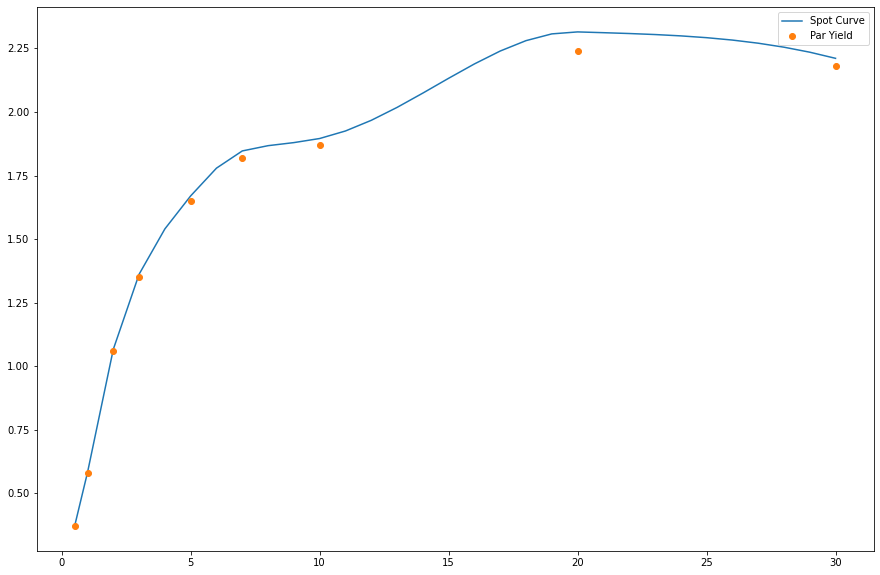

In [6]:
plt.plot(spot_rate_maturity, syld, label="Spot Curve")
plt.plot(maturity_h15, pyld, 'o', label="Par Yield")
plt.legend()
plt.show()